In [409]:
import pandas as pd
import psycopg2
from collections import Counter
import matplotlib.pyplot as plt


## Read the CSV data into dataframe. Rename the columns for better understanding. 

In [410]:
df = pd.read_csv("C:/Users/sowmk/Documents/python/case/data.csv")
df.columns = ['title','genre','tags','languages','Movie_Series','hidden_gem_score','country_available','runtime',
'director','writer','actors','view_rating','imdb_score','rotten_tomatoes_score','metacritic_score','awards_received',
'awards_nominated_for','box_office','release_date','netflix_relase_date','production_house','netflix_link','imdb_link',
'summary','imdb_votes','image','poster','tmdb_trailer','trailer_site']

## To identify the 2 sets of records - Movies and Series with their counts.

In [411]:
df['Movie_Series'].value_counts()

Movie     11697
Series     3783
Name: Movie_Series, dtype: int64

## Create movies data fact :

In [412]:
movies = df[df['Movie_Series'] == "Movie"].reset_index(level = 0)
movie_id = movies.index +1
movies.insert(0,"movie_id",movie_id)

movies_df = movies[['movie_id','title', 'Movie_Series','runtime','view_rating','imdb_score','rotten_tomatoes_score','metacritic_score','box_office','awards_received','release_date','netflix_relase_date']]
movies_df.head()

,movie_id,title,Movie_Series,runtime,view_rating,imdb_score,rotten_tomatoes_score,metacritic_score,box_office,awards_received,release_date,netflix_relase_date
0,1,HOW TO BUILD A GIRL,Movie,1-2 hour,R,5.8,79.0,69.0,"$70,632",1.0,08 May 2020,2021-03-04
1,2,Centigrade,Movie,1-2 hour,Unrated,4.3,NaN,46.0,"$16,263",NaN,28 Aug 2020,2021-03-04
2,3,Moxie,Movie,1-2 hour,NaN,6.3,NaN,NaN,NaN,NaN,22 Sep 2011,2021-03-04
3,4,The Con-Heartist,Movie,> 2 hrs,NaN,7.4,NaN,NaN,NaN,NaN,03 Dec 2020,2021-03-03
4,5,Only a Mother,Movie,1-2 hour,NaN,6.7,NaN,NaN,NaN,2.0,31 Oct 1949,2021-03-03


## Convert the run times values as quantifiable :
### [1-2 hour :  120] and  [> 2 hrs :  180]
### [< 30 minutes : 30] and  [30-60 mins : 60]

In [413]:
movies_df.runtime.drop_duplicates()

runtime_conversion = {"1-2 hour":120,"> 2 hrs":180,"< 30 minutes":30,"30-60 mins":60}
movies_df = movies_df.replace({"runtime":runtime_conversion})
movies_df.head()

,movie_id,title,Movie_Series,runtime,view_rating,imdb_score,rotten_tomatoes_score,metacritic_score,box_office,awards_received,release_date,netflix_relase_date
0,1,HOW TO BUILD A GIRL,Movie,120,R,5.8,79.0,69.0,"$70,632",1.0,08 May 2020,2021-03-04
1,2,Centigrade,Movie,120,Unrated,4.3,NaN,46.0,"$16,263",NaN,28 Aug 2020,2021-03-04
2,3,Moxie,Movie,120,NaN,6.3,NaN,NaN,NaN,NaN,22 Sep 2011,2021-03-04
3,4,The Con-Heartist,Movie,180,NaN,7.4,NaN,NaN,NaN,NaN,03 Dec 2020,2021-03-03
4,5,Only a Mother,Movie,120,NaN,6.7,NaN,NaN,NaN,2.0,31 Oct 1949,2021-03-03


## Update the Null values of the dataframe:

In [414]:
movies_df = movies_df.fillna({'view_rating':'NA','production_house':'NA'})
movies_df = movies_df.fillna({'imdb_score':0,'rotten_tomatoes_score':0, 'metacritic_score':0 ,
                               'awards_received':0,'box_office':0})

movies_df.head()

,movie_id,title,Movie_Series,runtime,view_rating,imdb_score,rotten_tomatoes_score,metacritic_score,box_office,awards_received,release_date,netflix_relase_date
0,1,HOW TO BUILD A GIRL,Movie,120,R,5.8,79.0,69.0,"$70,632",1.0,08 May 2020,2021-03-04
1,2,Centigrade,Movie,120,Unrated,4.3,0.0,46.0,"$16,263",0.0,28 Aug 2020,2021-03-04
2,3,Moxie,Movie,120,NA,6.3,0.0,0.0,0,0.0,22 Sep 2011,2021-03-04
3,4,The Con-Heartist,Movie,180,NA,7.4,0.0,0.0,0,0.0,03 Dec 2020,2021-03-03
4,5,Only a Mother,Movie,120,NA,6.7,0.0,0.0,0,2.0,31 Oct 1949,2021-03-03


## Categorise the different rating as either of the below values:
### 1. Everyone - All users can watch
### 2. Cautious - Parental Guidance advised
### 3. Restricted - Can be watched only by adults

In [415]:
rating = {'R' : 'Restricted','Unrated' : 'NA','NA':'NA','PG-13':'Cautious','PG':'Everyone','TV-Y7':'Everyone','Not Rated':'NA',
'TV-14' : 'Cautious','Approved' : 'Everyone','TV-MA' : 'Restricted','G':'Everyone','Passed':'Everyone',
'TV-Y': 'Everyone','TV-PG' : 'Restricted', 'GP': 'Cautious','TV-G' : 'Everyone','MA-17' : 'Cautious','UNRATED' : 'NA',
'M/PG': 'Cautious','TV-Y7-FV': 'Everyone','X': 'Restricted','NC-17':'Restricted','NOT RATED': 'NA',
'E': 'Cautious','E10+': 'Everyone'}
movies_df = movies_df.replace({"view_rating":rating})
movies_df.head()

,movie_id,title,Movie_Series,runtime,view_rating,imdb_score,rotten_tomatoes_score,metacritic_score,box_office,awards_received,release_date,netflix_relase_date
0,1,HOW TO BUILD A GIRL,Movie,120,Restricted,5.8,79.0,69.0,"$70,632",1.0,08 May 2020,2021-03-04
1,2,Centigrade,Movie,120,NA,4.3,0.0,46.0,"$16,263",0.0,28 Aug 2020,2021-03-04
2,3,Moxie,Movie,120,NA,6.3,0.0,0.0,0,0.0,22 Sep 2011,2021-03-04
3,4,The Con-Heartist,Movie,180,NA,7.4,0.0,0.0,0,0.0,03 Dec 2020,2021-03-03
4,5,Only a Mother,Movie,120,NA,6.7,0.0,0.0,0,2.0,31 Oct 1949,2021-03-03


## All the box office values are in USD dollar amounts. Removing the USD Dollar symbol and defaulting the amount as 0(Zero)

In [416]:
movies_df['box_office'] = movies_df['box_office'].str.strip("$")
movies_df['box_office'] = movies_df['box_office'].str.replace(",","")
movies_df['box_office'] = movies_df['box_office'].fillna('0')
movies_df['box_office'].astype('int64')
movies_df[['movie_id', 'title','box_office']].head()

,movie_id,title,box_office
0,1,HOW TO BUILD A GIRL,70632
1,2,Centigrade,16263
2,3,Moxie,0
3,4,The Con-Heartist,0
4,5,Only a Mother,0


##  Update the release date with default values and conver to datetime data type
##  Calculate the actual release year and quarter of the movie

In [417]:
movies_df['release_date']  = pd.to_datetime(movies_df['release_date'])
movies_df['release_date']  = movies_df['release_date'].fillna(pd.to_datetime("2099-12-31"))

release_yr = movies_df['release_date'].dt.year
release_qtr = movies_df['release_date'].dt.quarter

movies_df.insert(11,"release_year",release_yr)
movies_df.insert(12,"release_qtr",release_qtr)

movies_df[['movie_id','title','release_date','release_year','release_qtr']].head()

,movie_id,title,release_date,release_year,release_qtr
0,1,HOW TO BUILD A GIRL,2020-05-08,2020,2
1,2,Centigrade,2020-08-28,2020,3
2,3,Moxie,2011-09-22,2011,3
3,4,The Con-Heartist,2020-12-03,2020,4
4,5,Only a Mother,1949-10-31,1949,4


### * Update the netflix release date with default values and conver to datetime data type
### * Calculate the netflix release year and quarter of the movie

In [418]:
movies_df['netflix_relase_date'] = pd.to_datetime(movies_df['netflix_relase_date'])

nt_release_yr = movies_df['netflix_relase_date'].dt.year
nt_release_qtr = movies_df['netflix_relase_date'].dt.quarter

movies_df.insert(14,"netflix_release_yr",nt_release_yr)
movies_df.insert(15,"netflix_release_qtr",nt_release_qtr)

movies_df[['movie_id','title','netflix_relase_date','netflix_release_yr','netflix_release_qtr']].head()

,movie_id,title,netflix_relase_date,netflix_release_yr,netflix_release_qtr
0,1,HOW TO BUILD A GIRL,2021-03-04,2021,1
1,2,Centigrade,2021-03-04,2021,1
2,3,Moxie,2021-03-04,2021,1
3,4,The Con-Heartist,2021-03-03,2021,1
4,5,Only a Mother,2021-03-03,2021,1


# Create Genre dataframe with all the genre flags

## Create a list of unique genres from the dataset

In [419]:
movies = movies.fillna({'genre':'NA', 'tags':'NA','languages':'NA' ,'production_house':'NA'})

genre_list = movies['genre'].str.split(",",expand =True).stack().reset_index(drop=True, level =1).rename('genre')
genre_list = genre_list.str.strip().to_list()
genre_list = [x.lower() for x in genre_list]

genre_top_names = list(set(genre_list))
genre_top_names = [x.replace("-","") for x in genre_top_names]
#genre_top_names

## create a dataframe with the genre details for each movie

In [420]:
genre_df = movies[['movie_id','title','genre']]
gdf_list = genre_df['genre'].to_dict()
#gdf_list


## Create flags for each genre and update the dataframe

In [421]:
gflags = {}

for k,v in gdf_list.items():
   #print(v)
   d1 = { x: 'N' for x in genre_top_names  }
   gflags[k] = d1
   for name in v.split(","):
      gflags[k][name.lower().strip().replace("-","")] ='Y'
   
#print(gflags)

gflags_df = pd.DataFrame(gflags)
gflags_df_upd = gflags_df.T
gflags_df_upd

genre_df = genre_df.join(gflags_df_upd)
genre_df.head()

,movie_id,title,genre,filmnoir,thriller,sport,news,western,horror,adventure,...,adult,animation,family,romance,documentary,drama,scifi,mystery,na,gameshow
0,1,HOW TO BUILD A GIRL,Comedy,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
1,2,Centigrade,"Drama, Thriller",N,Y,N,N,N,N,N,...,N,N,N,N,N,Y,N,N,N,N
2,3,Moxie,"Animation, Short, Drama",N,N,N,N,N,N,N,...,N,Y,N,N,N,Y,N,N,N,N
3,4,The Con-Heartist,"Comedy, Romance",N,N,N,N,N,N,N,...,N,N,N,Y,N,N,N,N,N,N
4,5,Only a Mother,Drama,N,N,N,N,N,N,N,...,N,N,N,N,N,Y,N,N,N,N


# Top 10 languages in the dataset 

In [422]:
lang_list = movies['languages'].str.split(",",expand =True).stack().reset_index(drop=True, level =1).rename('genre')
lang_list = lang_list.str.strip().to_list()
lang_list = dict(Counter([x.lower() for x in lang_list]) )
lang_list = dict(sorted(lang_list.items(), key = lambda item: item[1]))
lang_list = {k:v for k,v in lang_list.items() if k != 'na'}

lang_list_df = pd.DataFrame(lang_list, index = [0])
lang_list_df = lang_list_df.T.rename(columns={0:'language'})
lang_list_df = lang_list_df.sort_values(by='language', ascending = False)
lang_list_df = lang_list_df.reset_index()
lang_list_df.head(10)


,index,language
0,english,6284
1,japanese,1080
2,spanish,912
3,french,895
4,german,549
5,hindi,495
6,korean,451
7,italian,432
8,mandarin,387
9,russian,300


# IMDB score distribution for the films

Top 5 Scores:
   imdb_score  count
5         6.0   3711
6         7.0   3139
7         8.0   1351
4         5.0   1321
3         4.0    535


Text(0.5, 1.0, 'IMDB score for Netflix films')

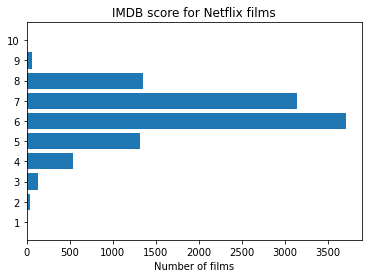

In [441]:
movies_df['title'] =movies_df['title'].str.lower()
movies_df['imdb_score'] = movies_df['imdb_score'].round()

imdb_score = movies_df[movies_df['imdb_score']> 0].groupby('imdb_score')['movie_id'].count().reset_index(name='count')
print("Top 5 Scores:")
print((imdb_score).sort_values(by='count', ascending = False).head(5))

plt.barh(imdb_score['imdb_score'], imdb_score['count'])
plt.xlabel("IMDB score")
plt.xlabel("Number of films")
plt.yticks(imdb_score['imdb_score'])
plt.title("IMDB score for Netflix films")

# Top 5 movies with the highest box office amount in Millions

In [472]:
movies_df['box_office'] = movies_df['box_office'].astype('int64')
box_office = movies_df[movies_df['box_office'] >0 ]

#box_office.
box_office = box_office[['title','box_office']].sort_values(by='box_office', ascending=False)
box_office['box_office'] = (box_office['box_office'].astype(float)/1000000).round(2)
box_office.head(5)


,title,box_office
10256,titanic,659.36
7889,jurassic world,652.39
10666,avengers assemble,623.36
10905,the dark knight,534.86
981,im losing it,474.54
